# Flight Delay Predictor

**Authors:**

Yusuf Medhat

Guillermo Bermejo Babiano 

## Data Loading

To improve the predicting power of the models, we will also take into account two of the available documentation datasets: `airports.csv`, `plane-data.csv` wich will be useful in the following steps.

The dataset `carriers.csv` will not be used as it does not provide any useful information for the purpose of this notebook.

### Session and Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, LongType, IntegerType, DoubleType, DateType
from pyspark.sql.functions import *
from pyspark.sql.functions import col, floor, avg, count, when

from pyspark.ml.feature import Imputer

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



# Create a SparkSession
spark = SparkSession.builder \
    .appName("FlightDelayPredictor") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/31 19:10:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Flight Dataset Loading

In [2]:
# Specify the list of files to load
files = [
    "../../training_data/flight_data/2006.csv.bz2",
    "../../training_data/flight_data/2007.csv.bz2",
    "../../training_data/flight_data/2008.csv.bz2"
]

# Explicit Schema Definition
# This maps to the 29 columns in your dataset
flight_schema = StructType([
    StructField("Year", IntegerType(), True),
    StructField("Month", IntegerType(), True),
    StructField("DayofMonth", IntegerType(), True),
    StructField("DayOfWeek", IntegerType(), True),
    StructField("DepTime", DoubleType(), True),
    StructField("CRSDepTime", DoubleType(), True),
    StructField("ArrTime", DoubleType(), True),           # Forbidden
    StructField("CRSArrTime", DoubleType(), True),
    StructField("UniqueCarrier", StringType(), True),
    StructField("FlightNum", IntegerType(), True),
    StructField("TailNum", StringType(), True),
    StructField("ActualElapsedTime", DoubleType(), True), # Forbidden
    StructField("CRSElapsedTime", DoubleType(), True),
    StructField("AirTime", DoubleType(), True),           # Forbidden
    StructField("ArrDelay", DoubleType(), True),          # TARGET
    StructField("DepDelay", DoubleType(), True),
    StructField("Origin", StringType(), True),
    StructField("Dest", StringType(), True),
    StructField("Distance", DoubleType(), True),
    StructField("TaxiIn", DoubleType(), True),            # Forbidden
    StructField("TaxiOut", DoubleType(), True),
    StructField("Cancelled", DoubleType(), True),
    StructField("CancellationCode", StringType(), True),
    StructField("Diverted", DoubleType(), True),          # Forbidden
    StructField("CarrierDelay", DoubleType(), True),      # Forbidden
    StructField("WeatherDelay", DoubleType(), True),      # Forbidden
    StructField("NASDelay", DoubleType(), True),          # Forbidden
    StructField("SecurityDelay", DoubleType(), True),     # Forbidden
    StructField("LateAircraftDelay", DoubleType(), True)  # Forbidden
])

# Load them all at once
df_flights = spark.read.csv(files, header=True, schema=flight_schema)

print(f"Total flights loaded: {df_flights.count()}")

Total flights loaded: 16984354


### Airport Dataset Loading

In [3]:
# Specify the list of file
airportFilePath = "../../training_data/documentation/airports.csv"

# Explicit Schema Definition
airport_schema = StructType([
    StructField("iata", StringType(), True),
    StructField("airport", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("country", StringType(), True),
    StructField("lat", DoubleType(), True),
    StructField("long", DoubleType(), True),
])

df_airports = spark.read.csv(airportFilePath, header=True, schema=airport_schema)

print(f"Total airports loaded: {df_airports.count()}")

Total airports loaded: 3376


### Plane Dataset Loading

In [4]:
# Specify the list of file
planeFilePath = "../../training_data/documentation/plane-data.csv"

# Explicit Schema Definition
plane_schema = StructType([
    StructField("tailnum", StringType(), True),
    StructField("type", StringType(), True),
    StructField("manufacturer", StringType(), True),
    StructField("issue_date", DateType(), True),
    StructField("model", StringType(), True),
    StructField("status", StringType(), True),
    StructField("aircraft_type", StringType(), True),
    StructField("engine_type", StringType(), True),
    StructField("year", IntegerType(), True),
])

df_planes = spark.read.csv(planeFilePath, header=True, schema=plane_schema)

print(f"Total planes loaded: {df_planes.count()}")

Total planes loaded: 5029


## Preprocessing & Cleaning

In [5]:
# ==============================================================================
# 1. DROP FORBIDDEN VARIABLES
# ==============================================================================
# These contain information known only AFTER the flight lands.
forbidden_vars = [
    "ArrTime", "ActualElapsedTime", "AirTime", "TaxiIn", "Diverted",
    "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay",
    "CancellationCode"
]
# Only drop columns that actually exist in the dataframe
cols_to_drop = [c for c in forbidden_vars if c in df_flights.columns]
df_clean = df_flights.drop(*cols_to_drop)

# ==============================================================================
# 2. FILTER INVALID ROWS
# ==============================================================================
# Filter Cancelled Flights: If Cancelled == 1, the plane never arrived.
# We also drop the 'Cancelled' column afterwards as it's now constant (all 0)
df_clean = df_clean.filter(col("Cancelled") == 0).drop("Cancelled")

# Drop Missing Targets: We cannot train on data where ArrDelay is missing
df_clean = df_clean.dropna(subset=["ArrDelay", "DepDelay", "Distance"])

print(f"Data Cleaning Complete. Remaining records: {df_clean.count()}")

Data Cleaning Complete. Remaining records: 16598211


## Exploratory Data Analysis (EDA)

In this section, we analyze the cleaned flight data to understand the underlying distributions and relationships. Our goal is to identify key drivers of delay to justify our feature engineering strategy. We focus on three specific hypotheses:

- Temporal Patterns: Are delays concentrated in specific "rush hours" or days?

- Operational Congestion: Do major hubs experience higher average delays than smaller airports?

- Equipment Reliability: Does the age of the aircraft correlate with delay frequency?

In [6]:
# Due to the size of the dataset, we cache it in memory for faster access
df_clean.cache()
print(f"Dataset cached. Total rows: {df_clean.count()}")

Dataset cached. Total rows: 16598211


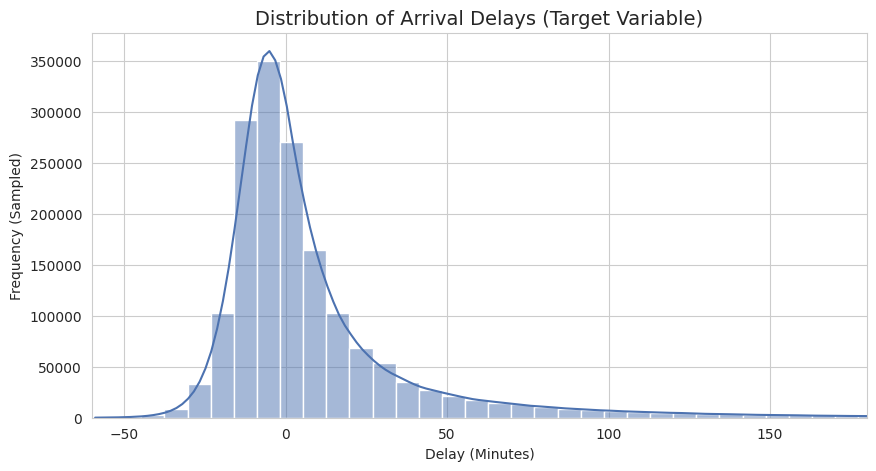

In [7]:
# ==============================================================================
# 1. UNIVARIATE ANALYSIS: The Target Variable (ArrDelay)
# ==============================================================================
# We sample the data for the histogram because plotting 10M points is slow/impossible
# We filter extreme outliers (>300 mins) just for the visualization clearly
target_sample = df_clean.select("ArrDelay") \
                        .filter((col("ArrDelay") > -60) & (col("ArrDelay") < 300)) \
                        .sample(withReplacement=False, fraction=0.1, seed=42) \
                        .toPandas()

plt.figure(figsize=(10, 5))
sns.histplot(target_sample['ArrDelay'], bins=50, kde=True, color="#4C72B0")
plt.title("Distribution of Arrival Delays (Target Variable)", fontsize=14)
plt.xlabel("Delay (Minutes)")
plt.ylabel("Frequency (Sampled)")
plt.xlim(-60, 180) # Focus on the main body of data
plt.show()

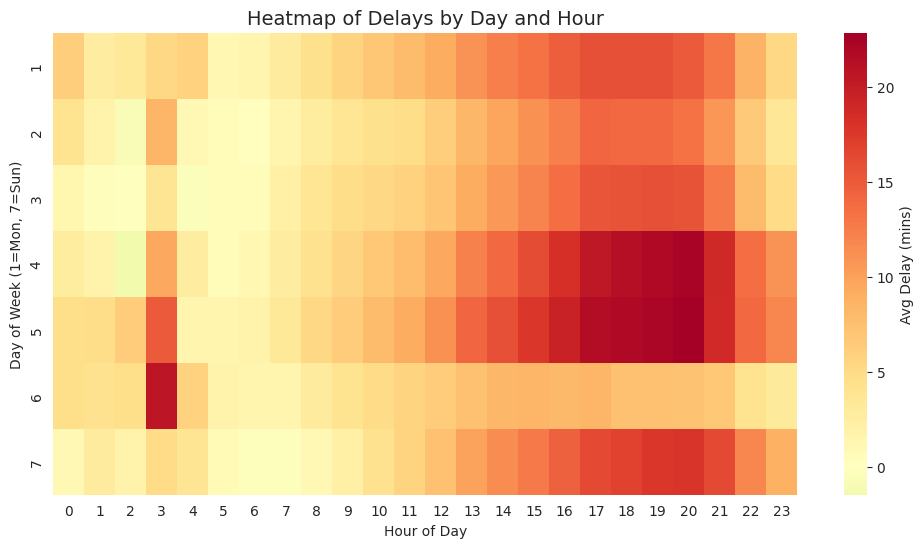

In [8]:
# ==============================================================================
# 2. MULTIVARIATE: Time Analysis (The "Rush Hour" Hypothesis)
# ==============================================================================
# Create a temporary Hour column for this plot
# 1430 -> 14
time_df = df_clean.withColumn("DepHour", floor(col("CRSDepTime") / 100))

# Aggregation: Average delay by Day of Week and Hour
heatmap_data = time_df.groupBy("DayOfWeek", "DepHour") \
                      .agg(avg("ArrDelay").alias("AvgDelay")) \
                      .orderBy("DayOfWeek", "DepHour") \
                      .toPandas()

# Pivot for Heatmap
heatmap_pivot = heatmap_data.pivot(index="DayOfWeek", columns="DepHour", values="AvgDelay")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_pivot, cmap="RdYlGn_r", center=0, cbar_kws={'label': 'Avg Delay (mins)'})
plt.title("Heatmap of Delays by Day and Hour", fontsize=14)
plt.ylabel("Day of Week (1=Mon, 7=Sun)")
plt.xlabel("Hour of Day")
plt.show()

/tmp/ipykernel_227096/717735682.py:19: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="AirportType", y="AvgDelay", data=hub_stats, palette="viridis")


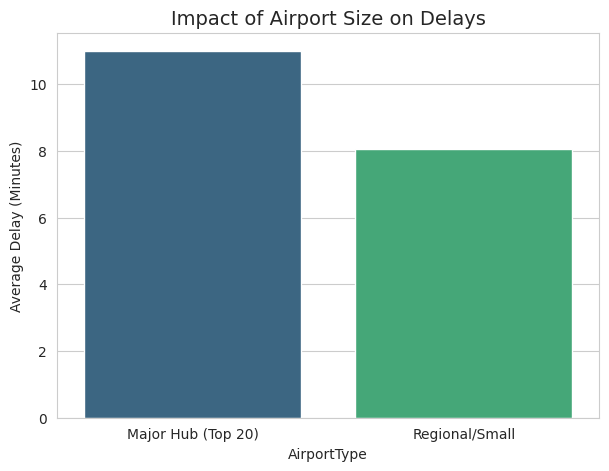

In [9]:
# ==============================================================================
# 3. MULTIVARIATE: Location Analysis (The "Hub" Hypothesis)
# ==============================================================================
# Identify Top 20 Airports
top_airports = df_clean.groupBy("Origin").count().orderBy(col("count").desc()).limit(20)
top_20_list = [row["Origin"] for row in top_airports.collect()]

# Tag airports as "Hub" or "Regional"
hub_df = df_clean.withColumn("AirportType", 
                             when(col("Origin").isin(top_20_list), "Major Hub (Top 20)")
                             .otherwise("Regional/Small"))

# Aggregate
hub_stats = hub_df.groupBy("AirportType") \
                  .agg(avg("ArrDelay").alias("AvgDelay")) \
                  .toPandas()

plt.figure(figsize=(7, 5))
sns.barplot(x="AirportType", y="AvgDelay", data=hub_stats, palette="viridis")
plt.title("Impact of Airport Size on Delays", fontsize=14)
plt.ylabel("Average Delay (Minutes)")
plt.show()

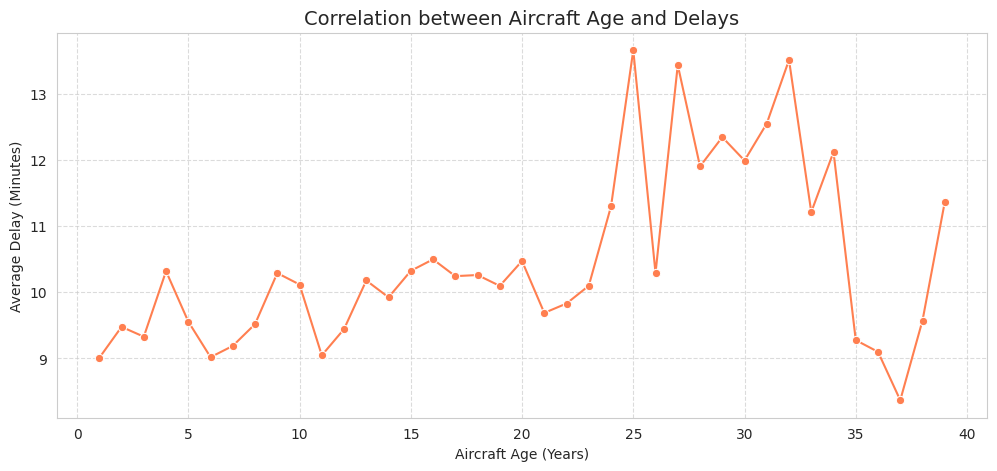

In [10]:
# ==============================================================================
# 4. MULTIVARIATE: Mechanics (The "Aging Fleet" Hypothesis)
# ==============================================================================
# We perform a temporary join just for this plot to prove 'PlaneAge' is useful
plane_age_df = df_clean.join(df_planes.withColumnRenamed("year", "PlaneYear"), df_clean.TailNum == df_planes.tailnum) \
                       .select((col("Year") - col("PlaneYear").cast("int")).alias("PlaneAge"), "ArrDelay") \
                       .filter((col("PlaneAge") > 0) & (col("PlaneAge") < 40)) # Filter impossible ages

# Aggregate by Age
age_stats = plane_age_df.groupBy("PlaneAge") \
                        .agg(avg("ArrDelay").alias("AvgDelay"), count("*").alias("FlightCount")) \
                        .filter(col("FlightCount") > 100) \
                        .orderBy("PlaneAge") \
                        .toPandas()

plt.figure(figsize=(12, 5))
sns.lineplot(x="PlaneAge", y="AvgDelay", data=age_stats, marker="o", color="coral")
plt.title("Correlation between Aircraft Age and Delays", fontsize=14)
plt.xlabel("Aircraft Age (Years)")
plt.ylabel("Average Delay (Minutes)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

/tmp/ipykernel_227096/1390102470.py:32: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="State", y="AvgDelay", data=subset_states, palette="coolwarm")


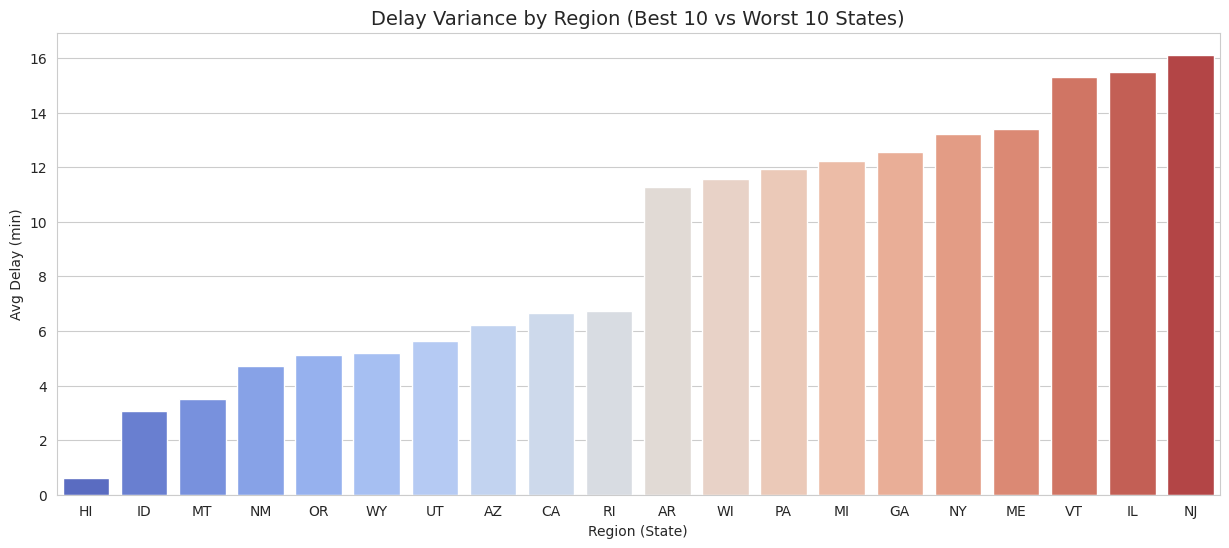

In [11]:
# ==============================================================================
# 5. REGION VS AIRPORT (Dimensionality Reduction)
# ==============================================================================
# Hypothesis: "State" captures enough pattern that we don't need OHE for 300+ airports.

# 1. Join Airport Data to get State/Lat/Long
# We rename columns immediately to avoid ambiguity
airports_eda = df_airports.select(
    col("iata").alias("Code"), 
    col("state").alias("State"), 
    col("lat").alias("Lat"), 
    col("long").alias("Long")
)

# Join just the Origin for this analysis
df_geo = df_clean.join(airports_eda, df_clean.Origin == airports_eda.Code, how="left")

# 2. Aggregation by State
state_stats = df_geo.groupBy("State") \
                    .agg(
                        avg("ArrDelay").alias("AvgDelay"), 
                        count("*").alias("FlightCount")
                    ) \
                    .filter(col("FlightCount") > 1000) \
                    .orderBy("AvgDelay") \
                    .toPandas()

# 3. Plot: State Variance
plt.figure(figsize=(15, 6))
# Show top 10 worst and top 10 best states to show the SPREAD of the data
subset_states = pd.concat([state_stats.head(10), state_stats.tail(10)])
sns.barplot(x="State", y="AvgDelay", data=subset_states, palette="coolwarm")
plt.title("Delay Variance by Region (Best 10 vs Worst 10 States)", fontsize=14)
plt.ylabel("Avg Delay (min)")
plt.xlabel("Region (State)")
plt.show()

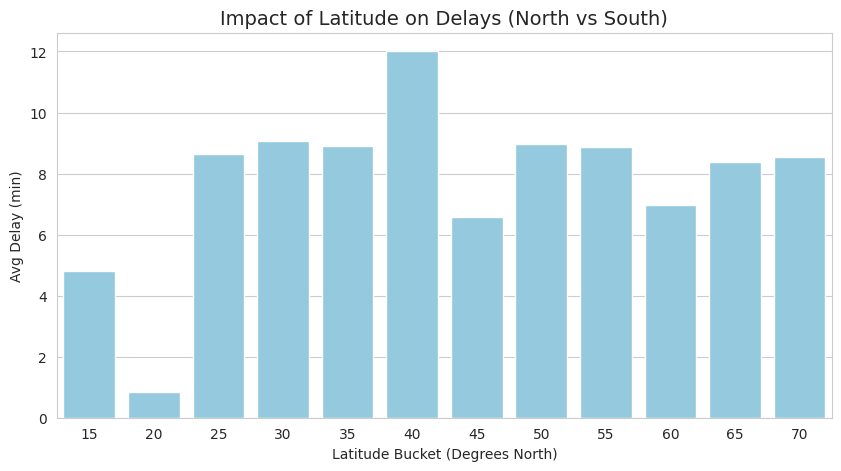

In [12]:
# ==============================================================================
# 6. LATITUDE ANALYSIS (The "Snow/Weather" Hypothesis)
# ==============================================================================
# Hypothesis: Higher Latitude (North) = More Snow/Storms = More Delay?

# We bin latitude into groups (e.g., <30 deg, 30-35, 35-40, >40)
# This makes the trend easier to see than a raw scatter plot
df_lat = df_geo.withColumn("LatBin", floor(col("Lat") / 5) * 5)

lat_stats = df_lat.groupBy("LatBin") \
                  .agg(avg("ArrDelay").alias("AvgDelay")) \
                  .orderBy("LatBin") \
                  .toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(x="LatBin", y="AvgDelay", data=lat_stats, color="skyblue")
plt.title("Impact of Latitude on Delays (North vs South)", fontsize=14)
plt.xlabel("Latitude Bucket (Degrees North)")
plt.ylabel("Avg Delay (min)")
plt.show()

/tmp/ipykernel_227096/3609387615.py:21: FutureWarning:                          

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")


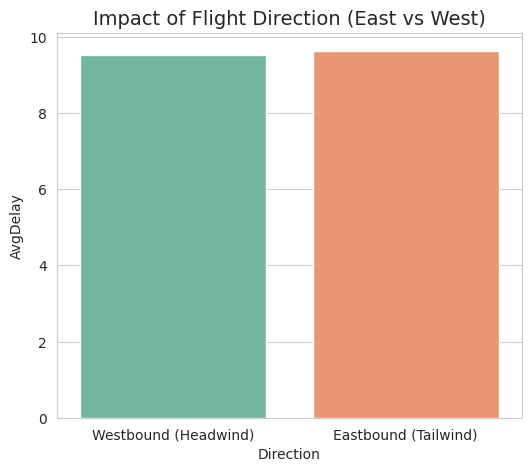

In [14]:
# ==============================================================================
# 7. FLIGHT DIRECTION (The "Jet Stream" Hypothesis)
# ==============================================================================
# Hypothesis: Flying East (Tailwind) recovers time? Flying West (Headwind) loses time?

# We need Destination Longitude to calculate direction
dest_coords = airports_eda.select(col("Code").alias("DestCode"), col("Long").alias("DestLong"))
df_direction = df_geo.join(dest_coords, df_geo.Dest == dest_coords.DestCode, how="left")

# Calculate Delta Longitude
# Positive = Eastbound, Negative = Westbound
df_direction = df_direction.withColumn("Direction", 
                                       when((col("DestLong") - col("Long")) > 0, "Eastbound (Tailwind)")
                                       .otherwise("Westbound (Headwind)"))

dir_stats = df_direction.groupBy("Direction") \
                        .agg(avg("ArrDelay").alias("AvgDelay")) \
                        .toPandas()

plt.figure(figsize=(6, 5))
sns.barplot(x="Direction", y="AvgDelay", data=dir_stats, palette="Set2")
plt.title("Impact of Flight Direction (East vs West)", fontsize=14)
plt.show()

### Conclusion of EDA
...

## Feature Engineering

1. **Aircraft data join**

   Join with `plane-data` to add aircraft-level attributes:

   * `manufacturer`
   * `model`
   * `aircraft`
   * `enginetype`
   * `age = year_flight - year_plane`

   Aircraft age is used as a proxy for reliability and maintenance effects.
   Drop `type`, `status` (no variance), and `issue_date` (not relevant for operations).

2. **Airport data join**

   Join airport metadata to both origin and destination:

   * `lat_ori`, `lon_ori`
   * `lat_dest`, `lon_dest`

   Coordinates are used to capture geographic and weather-related effects.

   Derived directional features:

   * `east_west`: 1 if eastbound, 0 if westbound
   * `north_south`: 1 if northbound, 0 if southbound

   These encode large-scale directional patterns (e.g. jet streams, traffic flows) without modeling full trajectories.

3. **Airport representation**

   Raw airport codes are not used due to high cardinality. Instead:

   * `is_hub`: binary indicator for Top 20 busiest airports (congestion proxy)
   * `region`: broad geographic region

   This retains operational signal while limiting dimensionality and overfitting risk.

## Model Training & Tuning

## Evaluation & Saving